In [6]:
import requests
import pandas as pd
import numpy as np
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib
from datetime import date
import datetime
import networkx as nx
import warnings
from pulp import * 
warnings.filterwarnings("ignore")
import xgboost as xgb

### Load the Dataset

In [7]:
# load base URL to easily populate syntax
url='https://divvy-tripdata.s3.amazonaws.com/Divvy_Trips_2019_Q3.zip'

# set up empty DataFrame
df=pd.DataFrame()

# get zip file from Divvy's servers
# if you're interested in browsing the data,
# it is publicly available at the link below
# https://divvy-tripdata.s3.amazonaws.com/index.html
res=requests.get(url)
temp_files=ZipFile(BytesIO(res.content))

# read the first file in the ZIP folder
df=pd.read_csv(temp_files.open(temp_files.namelist()[0]), thousands=',')

# output DataFrame so we can see what it looks like
df=df.replace({'Subscriber': 1, 'Customer': 0,'Male': 1,'Female': 0})
df.head(15)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,23479388,2019-07-01 00:00:27,2019-07-01 00:20:41,3591,1214.0,117,Wilton Ave & Belmont Ave,497,Kimball Ave & Belmont Ave,1,1.0,1992.0
1,23479389,2019-07-01 00:01:16,2019-07-01 00:18:44,5353,1048.0,381,Western Ave & Monroe St,203,Western Ave & 21st St,0,NaN,NaN
2,23479390,2019-07-01 00:01:48,2019-07-01 00:27:42,6180,1554.0,313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,0,NaN,NaN
3,23479391,2019-07-01 00:02:07,2019-07-01 00:27:10,5540,1503.0,313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,0,NaN,NaN
4,23479392,2019-07-01 00:02:13,2019-07-01 00:22:26,6014,1213.0,168,Michigan Ave & 14th St,62,McCormick Place,0,NaN,NaN
5,23479393,2019-07-01 00:02:21,2019-07-01 00:07:31,4941,310.0,300,Broadway & Barry Ave,232,Pine Grove Ave & Waveland Ave,1,1.0,1990.0
6,23479394,2019-07-01 00:02:24,2019-07-01 00:23:12,3770,1248.0,168,Michigan Ave & 14th St,62,McCormick Place,0,NaN,NaN
7,23479395,2019-07-01 00:02:26,2019-07-01 00:28:16,5442,1550.0,313,Lakeview Ave & Fullerton Pkwy,144,Larrabee St & Webster Ave,0,NaN,NaN
8,23479396,2019-07-01 00:02:34,2019-07-01 00:28:57,2957,1583.0,43,Michigan Ave & Washington St,195,Columbus Dr & Randolph St,0,NaN,NaN
9,23479397,2019-07-01 00:02:45,2019-07-01 00:29:14,6091,1589.0,43,Michigan Ave & Washington St,195,Columbus Dr & Randolph St,0,NaN,NaN


In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.describe()

,trip_id,bikeid,tripduration,from_station_id,to_station_id,usertype,gender,birthyear
count,1640718.000,1640718.000,1640718.000,1640718.000,1640718.000,1640718.000,1353368.000,1362624.000
mean,24364471.070,3349.856,1741.739,202.398,203.901,0.700,0.707,1984.903
std,499548.449,1888.878,38503.439,156.723,156.699,0.458,0.455,10.606
min,23479388.000,1.000,61.000,2.000,2.000,0.000,0.000,1888.000
25%,23935498.250,1713.000,465.000,77.000,80.000,0.000,0.000,1980.000
50%,24367415.500,3419.000,813.000,174.000,176.000,1.000,1.000,1988.000
75%,24797400.750,4997.000,1460.000,289.000,291.000,1.000,1.000,1992.000
max,25223639.000,6471.000,9056633.000,673.000,673.000,1.000,1.000,2003.000


# Machine Learning: Classification

### Stratified Sampling 

In [9]:
#in original dataset, the usertype 0 and 1 is 30% / 70%
ml=df[['usertype','gender','birthyear','tripduration']]
ml.query("usertype==0")

,usertype,gender,birthyear,tripduration
1,0,NaN,NaN,1048.000
2,0,NaN,NaN,1554.000
3,0,NaN,NaN,1503.000
4,0,NaN,NaN,1213.000
6,0,NaN,NaN,1248.000
...,...,...,...,...
1640703,0,NaN,1999.000,1257.000
1640706,0,NaN,NaN,1620.000
1640711,0,NaN,NaN,2063.000
1640712,0,NaN,NaN,2049.000


In [10]:
#there are 491694 records where usertype is 0
st_sample=ml.groupby('usertype', group_keys=False).apply(lambda x: x.sample(491694))

In [11]:
#now the usertype for 1 and 0 are 50%/50%
st_sample

,usertype,gender,birthyear,tripduration
560989,0,1.000,1990.000,757.000
764571,0,1.000,1985.000,824.000
169122,0,0.000,1991.000,833.000
1146126,0,0.000,1984.000,807.000
1607573,0,1.000,1991.000,2417.000
...,...,...,...,...
827611,1,0.000,1973.000,684.000
412253,1,1.000,1984.000,404.000
1190854,1,1.000,1991.000,189.000
279375,1,1.000,1994.000,389.000


In [12]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(st_sample[['tripduration','gender','birthyear']], st_sample['usertype'], test_size = 0.25)

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model = XGBClassifier()
model.fit(train_x, train_y)
# make predictions for test data
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[17:38:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 84.04%


Above, we see our model has an accuracy between 83% and 85%. It's a good model, likely because it has been stratified.

# Machine Learning: Linear Regression

### Cleaning the data

We can see from the code cell below that certain columns aren't in their desired format. Before we work with the data, we transform these column to the right dtype.

In [14]:
df.dtypes

trip_id                int64
start_time            object
end_time              object
bikeid                 int64
tripduration         float64
from_station_id        int64
from_station_name     object
to_station_id          int64
to_station_name       object
usertype               int64
gender               float64
birthyear            float64
dtype: object

In [15]:
# convert datetime columns to datetime types
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

In [16]:
from sklearn.linear_model import LinearRegression

First, we want to predict how many bikes will leave a station at a particular time/hour. This is an important question for demand forecasting.

Let's choose the station at Canal and Adams. This is the Divvy station right outside Union Station. In the mornings, commuters from the suburbs arrive and Divvy short distances to their workplaces in the city. In the evenings, they bike back to Union Station to go back home.

It is important to note the model can be trained on any other station just as easily. We chose to not train our model on every station all at once because different stations have different idiosyncracies. Residential stations (and Union Station) empty out at 8am and commercial ones fill up in the morning.

In [17]:
# filter only Union Station values

unionst = df[df.from_station_name == "Canal St & Adams St"]
unionst = unionst.set_index('start_time')

In [18]:
# remove columns we don't need
# keep an extra column else pandas converts this to a series
unionst = unionst.resample('H').count().iloc[:,:2]
unionst

,trip_id,end_time
start_time,,
2019-07-01 04:00:00,1,1
2019-07-01 05:00:00,4,4
2019-07-01 06:00:00,25,25
2019-07-01 07:00:00,55,55
2019-07-01 08:00:00,53,53
...,...,...
2019-09-30 17:00:00,62,62
2019-09-30 18:00:00,32,32
2019-09-30 19:00:00,8,8


We can see the number of bikes checked out from Union Station has a seasonal factor to it.

<AxesSubplot:xlabel='start_time'>

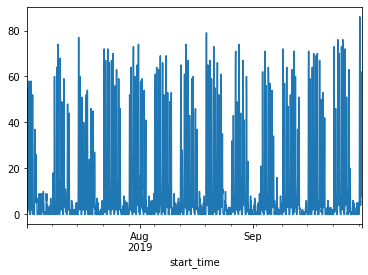

In [19]:
unionst.trip_id.plot()

In [20]:
# create columns to log the values of day and hour
# these functions return a number
unionst['day'] = unionst.index.day_of_week
unionst['hour'] = unionst.index.hour

# delete the extra column
del unionst['end_time']

Now, we want to run two different verions of our model.

The first one will use day and hour as is after transforming to dummy variables. The second will group hour into morning, evening, and night; and day into weekend and weekday.

### Version 1

In [21]:
# tranform each hour and each day of week to a dummy variable
# we're left with 7 days + 24 hours i.e. 31 dummy variables
unionst_all = unionst
unionst_all = pd.concat([unionst_all, pd.get_dummies(unionst_all.day, prefix='day')], axis=1)
unionst_all = pd.concat([unionst_all, pd.get_dummies(unionst_all.hour, prefix='hour')], axis=1)

# delete original columns
del unionst_all['day'], unionst_all['hour']
unionst_all

,trip_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
start_time,,,,,,,,,,,,,,,,,,,,,
2019-07-01 04:00:00,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-07-01 05:00:00,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-07-01 06:00:00,25,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-07-01 07:00:00,55,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-07-01 08:00:00,53,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30 17:00:00,62,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2019-09-30 18:00:00,32,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2019-09-30 19:00:00,8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
# run a linear regression and print out R2
reg = LinearRegression().fit(unionst_all.iloc[:,1:], unionst_all.iloc[:,0])
reg.score(unionst_all.iloc[:,1:], unionst_all.iloc[:,0])

0.6373691035548146

##### Above, we see our model has an R<sup>2</sup> of around 63%. This isn't bad! Let's try grouping our data to see if that gives us a higher accuracy.

### Version 2

In [23]:
unionst_grp = unionst
unionst_grp

,trip_id,day,hour
start_time,,,
2019-07-01 04:00:00,1,0,4
2019-07-01 05:00:00,4,0,5
2019-07-01 06:00:00,25,0,6
2019-07-01 07:00:00,55,0,7
2019-07-01 08:00:00,53,0,8
...,...,...,...
2019-09-30 17:00:00,62,0,17
2019-09-30 18:00:00,32,0,18
2019-09-30 19:00:00,8,0,19


In [24]:
# encode the day column where a 0 is a weekday
# and a 1 is a weekend
unionst_grp['day'] = np.where(unionst_grp.day < 5, 0,1)

# 0–8 is considered morning
# 9–4 is considered afternoon
# 5–12 is considered evening
unionst_grp['hour'] = np.where(unionst_grp['hour'] < 9, 'morn', np.where(unionst_grp['hour'] < 17, 'afternoon', 'evening'))
unionst_grp = pd.concat([unionst_grp, pd.get_dummies(unionst_grp.hour)], axis=1)

# delete the columns we don't need
del unionst_grp['hour']

In [25]:
# run a regression and print out R2
reg_grp = LinearRegression().fit(unionst_grp.iloc[:,1:], unionst_grp.iloc[:,0])
reg_grp.score(unionst_grp.iloc[:,1:], unionst_grp.iloc[:,0])

0.09674500328951863

We can see that this model is terrible. Going from a model with 63% accuracy to one with 10% accuracy is a huge downgrade, and it would make more sense to use the first model.

# Graph: Solving the Traveling Salesperson's Problem

Suppose once every while, the city of Chicago DoT would like to make an inspection of each bike station. To do this, it would need to go through and visit all stations. However, in order to minimize the amount of time spent traveling from between station, it would want to hit each station exactly once (because anything greater would be a waste of resources).

To find the quickest path through all stations (nodes), the DoT would have to solve the Traveling Salesperson's Problem. Luckily, networkx has a built-in function to help with this.

### Creating a graph

In [26]:
ntwrk_df = df.groupby(['from_station_name', 'to_station_name']).mean().reset_index().loc[:, ['from_station_name', 'to_station_name', 'tripduration']].sort_values(by='tripduration', ascending='False')

In [27]:
ntwrk_df.head(10)

,from_station_name,to_station_name,tripduration
26796,DIVVY Map Frame B/C Station,DIVVY Map Frame B/C Station,93.500
42103,Halsted St & 37th St,Halsted St & 35th St,111.700
70179,Ogden Ave & Roosevelt Rd,Western Ave & Fillmore St (*),114.000
42029,Halsted St & 35th St,Halsted St & 37th St,118.750
96197,Wentworth Ave & 33rd St,Wentworth Ave & 35th St,121.000
25729,Clybourn Ave & Division St,Orleans St & Elm St,126.200
99969,Wolcott Ave & Polk St,Hermitage Ave & Polk St,133.078
2186,Artesian Ave & Hubbard St,Smith Park (*),137.000
13282,Canal St & Harrison St,Canal St & Jackson Blvd,138.958
13299,Canal St & Harrison St,Clinton St & Polk St,140.000


In [28]:
mask=pd.DataFrame(df['from_station_name'].value_counts()>500).reset_index().query('from_station_name==True')
ntwrk_df=pd.merge(ntwrk_df,mask,left_on='from_station_name',right_on='index').drop(columns=['from_station_name_y','index']).rename(columns={"from_station_name_x": "from_station_name"})     
ntwrk_df

,from_station_name,to_station_name,tripduration
0,Ogden Ave & Roosevelt Rd,Western Ave & Fillmore St (*),114.000
1,Ogden Ave & Roosevelt Rd,Fairfield Ave & Roosevelt Rd,261.000
2,Ogden Ave & Roosevelt Rd,Western Ave & Congress Pkwy,296.500
3,Ogden Ave & Roosevelt Rd,Wolcott Ave & Polk St,370.720
4,Ogden Ave & Roosevelt Rd,Washtenaw Ave & Ogden Ave,376.343
...,...,...,...
93856,Lake Shore Dr & Monroe St,Cicero Ave & Quincy St,48057.000
93857,Lake Shore Dr & Monroe St,Canal St & Taylor St,142363.200
93858,Lake Shore Dr & Monroe St,Ashland Ave & McDowell Ave,882253.000
93859,Lake Shore Dr & Monroe St,Canal St & Jackson Blvd,1245552.500


In [29]:
#create graph using station name
G=nx.from_pandas_edgelist(df, "from_station_name", "to_station_name", edge_attr="tripduration", create_using=nx.Graph())

In [30]:
nx.algorithms.approximation.greedy_tsp(G)

NetworkXError: G must be a complete graph.

### Here, we run into an error because the graph is not complete. This is most likely because we filtered out rides in the initial data loading process. To work around this, we use networkx's ```complete_graph``` function.

In [32]:
tsp_sol=nx.algorithms.approximation.greedy_tsp(nx.complete_graph(G))
tsp_sol

['Wilton Ave & Belmont Ave',
 'Damen Ave & Division St',
 'Kimball Ave & Belmont Ave',
 'Chicago Ave & Dempster St',
 'Western Ave & 21st St',
 'Halsted St & 35th St',
 'Laramie Ave & Gladys Ave',
 'Hoyne Ave & 47th St',
 'South Chicago Ave & Elliot Ave',
 'Greenwood Ave & 79th St',
 'Canal St & Monroe St',
 'Damen Ave & Pierce Ave',
 'Broadway & Ridge Ave',
 'Western Ave & Congress Pkwy',
 'Green St & Randolph St',
 'State St & 29th St',
 'Ashland Ave & Archer Ave',
 'Western Ave & Granville Ave',
 'Rockwell St & Eastwood Ave',
 'Desplaines St & Jackson Blvd',
 'South Shore Dr & 67th St',
 'Sheffield Ave & Wellington Ave',
 'Clark St & Lunt Ave',
 'Austin Blvd & Lake St',
 'Manor Ave & Leland Ave',
 'Stony Island Ave & South Chicago Ave',
 'Western Ave & 28th St',
 'Clark St & Lake St',
 'Prairie Ave & Garfield Blvd',
 'Rush St & Superior St',
 'Larrabee St & Kingsbury St',
 'Bennett Ave & 79th St',
 'Cherry Ave & Blackhawk St',
 'Racine Ave & 13th St',
 'Dearborn St & Adams St',
 'Un

From above, we see the algorithm returns a solution to the problem. The function is labeled as greedy and approximate, however, we see from below that the solution is the true, global solution for our network.

In [33]:
len(nx.algorithms.approximation.greedy_tsp(nx.complete_graph(G)))

614

In [34]:
len(G.nodes())

613

The one extra node in the TSP solution is the first station again. Therefore, we found a solution to the TSP.

# Graph: Bellman ford 

In [35]:
# we want to remove those trips that are greaterthan 15 minutes as we assume tourists are lazy
df = df[df.tripduration <= 60*15]
mask=pd.DataFrame(df['from_station_name'].value_counts()>500).reset_index().query('from_station_name==True')
ntwrk_df=pd.merge(ntwrk_df,mask,left_on='from_station_name',right_on='index').drop(columns=['from_station_name_y','index']).rename(columns={"from_station_name_x": "from_station_name"})    
#create graph using station name
G=nx.from_pandas_edgelist(ntwrk_df, "from_station_name", "to_station_name", edge_attr="tripduration", create_using=nx.Graph())

In [36]:
#bellman-ford
def lookingForShortest(G,NameOfTheStation):
    pred, dist = nx.single_source_bellman_ford(G, NameOfTheStation , weight='tripduration')
    return sorted(pred.items())#, sorted(dist.items())

In [ ]:
NameOfTheStation=input("Please input the station name, for example: Canal St & Adams St")
lookingForShortest(G,NameOfTheStation)

# Linear Programming: Minimum vertex cover

Let's say the DoT wants to create a charger exchange system (similar to <a href="https://www.gogoro.com/">Gogoro</a>) in order to promote other electric vehicles. They would like to do this at Divvy stations. But setting up a charging station costs a lot, so we only need to set up charging stations at the stations that have the most connections/movement. In particular, we would like stations (nodes) that connect all the routes (edges). In order to do that, we use minimum vertex cover to find out how many charger stations we need and those station's name.

In [ ]:
prob = LpProblem("MinimumVertexCover",LpMinimize)

# variable
#create a dict for every node. 1 for choosing this node, 0 for not choosing
x = LpVariable.dicts("node", G.nodes(), cat='Binary')

# constraint
# every edge must be cover
for (i,j) in G.edges():
    prob += x[i] + x[j] >= 1
        
# objective
prob += lpSum(x)
    
# solve
prob.solve()
for variable in prob.variables():
    if variable.varValue==1.0:
        print(variable.name)

In [ ]:
print(int(value(prob.objective)))

In [ ]:
len(G.nodes)

Compared to building a charging station at every Divvy station, now we only need to build 350 stations.

# Graph: centrality, finding the busiest nodes

Another way to determine the best stations to set up charging stations is to find key Divvy stations. These are the most “influential” stations and are relatively important. Note how Canal and Adams is on here (Union Station, from the example above).

In [ ]:
s=nx.algorithms.centrality.degree_centrality(G)

# set and determine a threshold
for i in s.keys():
    if s[i]>0.6:
        print(i)